# Notes on Recurrent Neural Networks

These are my notes from chapter 15 of "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" by Aurelien Geron. Code from the chapter is used here. The point of this notebook is to collect an understanding of the concepts behind RNN's for use in future projects.

# What is an RNN?

A Recurrent Neural Network is used for processing of sequences. For example, predicting the next frame in movie. Or predicting the next word in a _________. 

RNN's differ from Feed Forward Nets whose layers take inputs and map them to outputs. To which these outputs serve as inputs only to the next layer. An RNN, however, feeds the outputs of a layer back into the layer as input.

This ability to feed the output back in as input is useful for sequential data because it allows the network to process sequences of arbitrary length. Whereas Feed Forward Networks have set input dimensions, an RNN can break up a sequence of any length into uniform "time steps" and process each time step individually. 

For example, imagine we take a sequence with 10 time steps and feed it into a single Recurrent Neuron. The Neuron will map the first time sequence to an output. Then it will feed this output back into the Neuron while also feeding the second time step into the neuron as input. This means that the Recurrent Neuron works through each time step one by one. And at each time step, the Neuron processes both the current time step and the output from the previous. This can be thought of as a sort of short term memory that RNNs takes advantage of to refine the output of each layer. What I have just outlined is how a simple Recurrent Neuron works. There are, however, more complicated versions. 

RNNs use a special type of Backpropagation that "unrolls" the time steps through time. Computing the gradient with respect to the weights at each time step moving backwards. This is called backpropagation through time, BPTT. This adaptation of backpropagation, while it allows for an RNN to be trained, also leads to unstable gradient issues during training such as vanishing or exploding gradients. BPTT is especially susceptable to this issue because of the amount of times the chain rule is applied to compute partial derivatives in a single neuron.

# Tensorflow Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

We will now implement an RNN to forecast the next value in a time series. The code used comes from the Hands-On textbook starting on page 504.

Time series data is typically stored in the form of a 3d tensor [batch_size, time_steps, dimensionality]. For example, if we have 1000 time series, each with 50 time steps, and each time step has 1 value, then the shape of the tensor would be [1000, 50, 1].

The below function generates time series data in this formatting. The time series is a sine wave with some noise added to the frequency and phase shift. 

In [6]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10) ) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 10 + 10) ) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

Next, we split this generated data into train, test, and validation sets.

Notice that the number of time steps in the argument of the generate_time_series() function is one more than the time steps specified. This is because we want to predict the next value in the time series after the last time step. When the data is split, we remove the last time step for the X sets and include it in the target sets. 

In [7]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)


X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print(f'X_train.shape: {X_train.shape}'), print(f'y_train.shape: {y_train.shape}')
print(f'X_valid.shape: {X_valid.shape}'), print(f'y_valid.shape: {y_valid.shape}')
print(f'X_test.shape: {X_test.shape}'), print(f'y_test.shape: {y_test.shape}')

X_train.shape: (7000, 50, 1)
y_train.shape: (7000, 1)
X_valid.shape: (2000, 50, 1)
y_valid.shape: (2000, 1)
X_test.shape: (1000, 50, 1)
y_test.shape: (1000, 1)


(None, None)

Here is a vsualization of each time series.

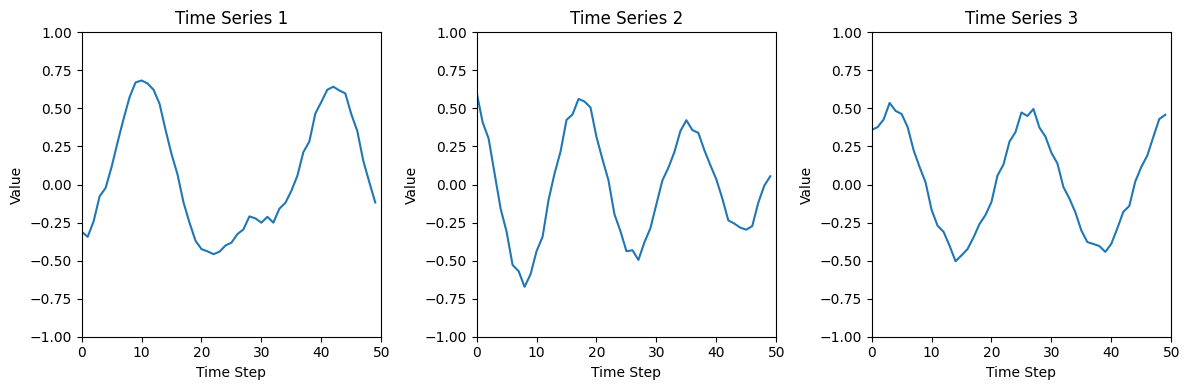

(None, None)

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i in range(3):
    axs[i].plot(X_train[i])
    axs[i].set_title(f'Time Series {i+1}')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Value')
    axs[i].set_xlim([0, 50]), axs[i].set_ylim([-1, 1])

plt.tight_layout(), plt.show()

# Baseline Metrics for RNNs

Next, we'll create baseline metrics that enable us to judge the performance of our model after training. Our first metric, Naive Forecasting, is a common method for judgeing whether an RNN has improved after training. It is MSE with the target and the time step immediately before it. 

Below we create a naive forecast for each time series in the test set and perform MSE to get a baseline metric.

In [9]:
y_pred = X_valid[:, -1] #get the last value of each time series
naive_forecast = np.mean(keras.losses.mean_squared_error(y_valid, y_pred)) # MSE 
print(f'Naive Forecast MSE: {naive_forecast}')

Naive Forecast MSE: 0.015727924183011055


Another metric is using a linear model to preduct the next time step val. We do this below with a single dense neuron with no activation function (this performs a linear combination)

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.1010 - val_loss: 0.0121
Epoch 2/20
219/219 [==============================] - 0s 923us/step - loss: 0.0082 - val_loss: 0.0064
Epoch 3/20
219/219 [==============================] - 0s 924us/step - loss: 0.0057 - val_loss: 0.0055
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 5/20
219/219 [==============================] - 0s 924us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 6/20
219/219 [==============================] - 0s 914us/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/20
219/219 [==============================] - 0s 909us/step - loss: 0.0039 - val_loss: 0.0039
Epoch 8/20
219/219 [==============================] - 0s 886us/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/20
219/219 [==============================] - 0s 884us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 10/20
219/219 [==============================] - 0s 924us/step - loss: 0.0032 - 

MSE shows that the linear model outperformed the naive forecast.

In [11]:
mse_test = model.evaluate(X_test, y_test)
print(f'MSE Test: {mse_test}')

32/32 [==============================] - 0s 675us/step - loss: 0.0023
MSE Test: 0.0022657986264675856


# Sequence to Vector

Next we'll train a simple RNN with one Neuron for comparison. 

Keras sets the default activation function of RNNs to tanh (range of [-1, 1]). This is because tanh is better at dealing with exploding gradients than sigmoid.

Also note that the input shape is [None, 1] because RNNs can process any length of sequence as long as the number if features per time step is known.

In [12]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 5ms/step - loss: 1.0336 - val_loss: 0.9873
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.9079 - val_loss: 0.8317
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.7904 - val_loss: 0.7423
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.6725 - val_loss: 0.5157
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.4495 - val_loss: 0.4042
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.3785 - val_loss: 0.3354
Epoch 7/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2905 - val_loss: 0.2745
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.2239 - val_loss: 0.2039
Epoch 9/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1685 - val_loss: 0.1549
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1407 - val_loss: 0.1411

The RNN outperforms the naive forecast but not the linear model.

In [13]:
#MSE
mse_test = model.evaluate(X_test, y_test)
print(f'MSE Test: {mse_test}')

 1/32 [..............................] - ETA: 0s - loss: 0.167932/32 [==============================] - 0s 1ms/step - loss: 0.1334
MSE Test: 0.13343966007232666


Next, we'll create a deep RNN with 20 neurons in each of the 3 layers. The hyperparameter return_sequences=True is used to tell the RNN to return the full sequence of outputs for each time step. If this is not set, the RNN will only return the last output. Remember that each SimpleRNN layer takes a sequence, so inputting only a scalar would not work for this model. This is also why the last layer doesnt have return_sequences=True, because this model is only predicting the most immediate next value. 

In [14]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.0049 - val_loss: 0.0030
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0018 - val_lo

The deep RNN outperforms the linear model.

In [15]:
mse_test = model.evaluate(X_test, y_test)
print(f'MSE Test: {mse_test}')

32/32 [==============================] - 0s 3ms/step - loss: 0.0019
MSE Test: 0.0018726796843111515


# Predicting into the Future

1/1 [==============================] - 0s 17ms/step


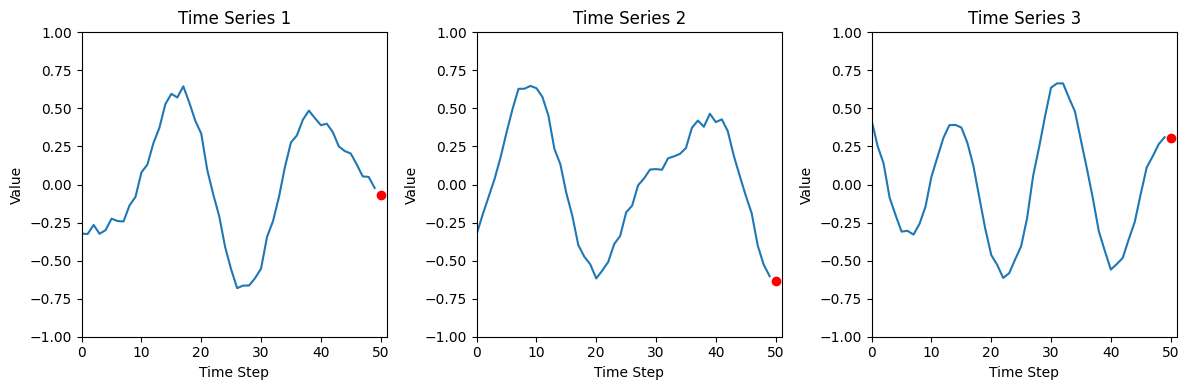

(None, None)

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i in range(3):
    #gen random integer
    example = np.random.randint(0, 1000)

    axs[i].plot(X_test[i + example])
    #predict the next time step value and plot it 
    axs[i].plot(50, model.predict(X_test[i + example][np.newaxis, :, :]), 'ro')

    axs[i].set_title(f'Time Series {i+1}')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Value')
    axs[i].set_xlim([0, 51]), axs[i].set_ylim([-1, 1])

plt.tight_layout(), plt.show()

Above we see a visualization of the models prediction. Visually, it appears to be performing well.

Something else we can do with this model is called recursive multi step forecasting. Which is the process of predicting the next value, then using that value as input to predict the next value, and so on. 

This is done in the code below. First the model is used to predict the next value in the time series. Then the predicted value is appended to the end of the time series and the model is used to predict the next value. When the process is repeated, the sequence gets shifted one step forward for input of the next prediction. 

In [17]:
series = generate_time_series(1, 50 + 10) # generate 1 series with an additional 10 steps
X_new, y_new = series[:, :50, :], series[:, 50:, :]  # split input and target
X = X_new

for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :] # predict the time next time step after shifting the input, then reshpaes the output back to a 3D tensor
                                                                    #this is because the model outputs a 2D tensor of shape (number of series, 1) ie one value per series. 
    X = np.concatenate([X, y_pred_one], axis=1) # here we concatenate the input with the predicted value and repeat the process for the next time step

y_pred = X[:, 50:, :]

1/1 [==============================] - 0s 16ms/step


Below we plot the results

1/1 [==============================] - 0s 16ms/step


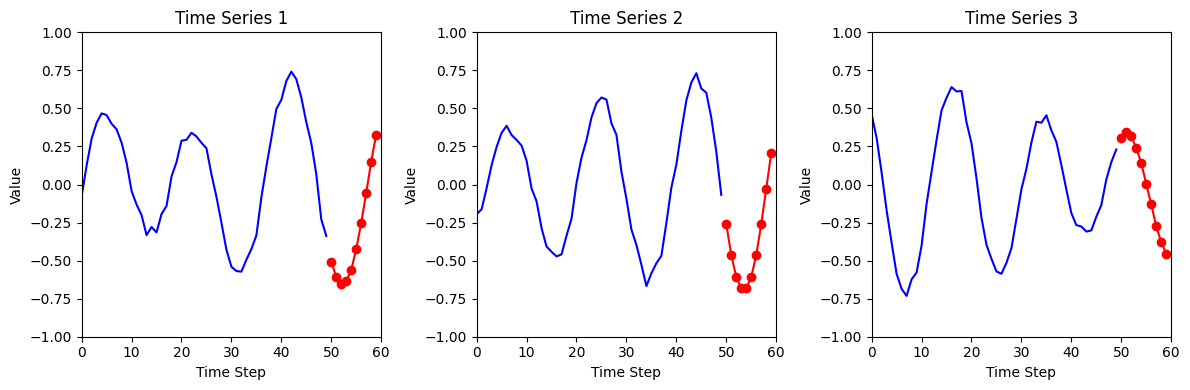

(None, None)

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i in range(3):
    # Generate random integer
    example = np.random.randint(0, 1000)

    # Prepare the input data
    X = X_test[i + example][np.newaxis, :, :]
    
    # Generate recursive multi-step forecasts
    for step_ahead in range(10):
        y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
        X = np.concatenate([X, y_pred_one], axis=1)
    
    y_pred = X[:, 50:, :]

    # Plot the original series and the forecasts
    axs[i].plot(X_test[i + example], 'b-')
    axs[i].plot(np.arange(50, 60), y_pred[0, :, 0], 'ro-')
    
    axs[i].set_title(f'Time Series {i+1}')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Value')
    axs[i].set_xlim([0, 60]), axs[i].set_ylim([-1, 1])

plt.tight_layout(), plt.show()

The downside of this approach is that error in next time step prediction compounds over time.

Another approach for predicting the next n values is to predict all n values at once. This involves changing the target dimmesions and the output dim of the model to reflect this change.

In [19]:
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0] #grab last ten features for targets
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0] 

print(f'X_train.shape: {X_train.shape}'), print(f'y_train.shape: {y_train.shape}')
print(f'X_valid.shape: {X_valid.shape}'), print(f'y_valid.shape: {y_valid.shape}')
print(f'X_test.shape: {X_test.shape}'), print(f'y_test.shape: {y_test.shape}')

X_train.shape: (7000, 50, 1)
y_train.shape: (7000, 10)
X_valid.shape: (2000, 50, 1)
y_valid.shape: (2000, 10)
X_test.shape: (1000, 50, 1)
y_test.shape: (1000, 10)


(None, None)

In [20]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0393 - val_loss: 0.0109
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0090 - val_loss: 0.0069
Epoch 3/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0056 - val_loss: 0.0068
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0044 - val_loss: 0.00

In [21]:
mse_test = model.evaluate(X_test, y_test)
print(f'MSE Test: {mse_test}')

32/32 [==============================] - 0s 2ms/step - loss: 0.0036
MSE Test: 0.003639184171333909


1/1 [==============================] - 0s 15ms/step


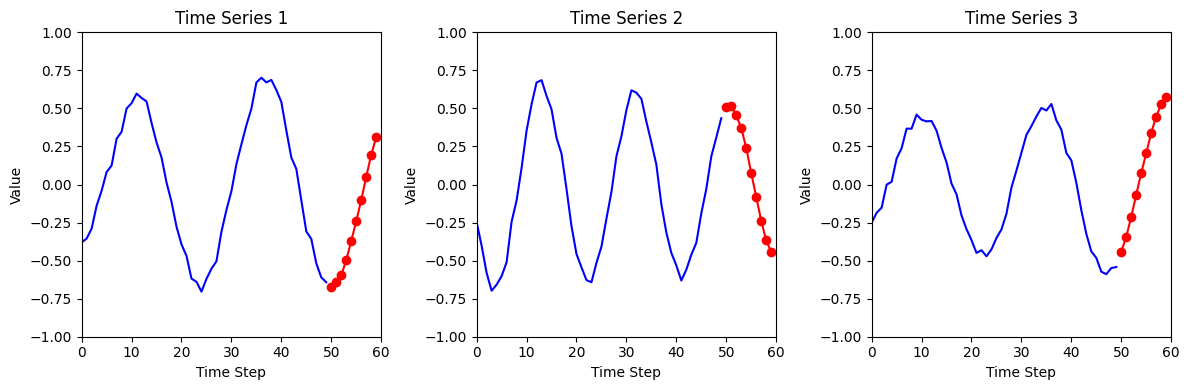

(None, None)

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for i in range(3):
    # Generate random integer
    example = np.random.randint(0, 1000)
    X_new = X_test[example:example+1] # Select one series
    y_pred = model.predict(X_new) # Predict 10 time steps

    axs[i].plot(range(50), X_new[0, :, 0], "b-") # Plot original series
    axs[i].plot(range(50, 60), y_pred[0, :], "ro-") # Plot predictions

    axs[i].set_title(f'Time Series {i+1}')
    axs[i].set_xlabel('Time Step')
    axs[i].set_ylabel('Value')
    axs[i].set_xlim([0, 60]), axs[i].set_ylim([-1, 1])

plt.tight_layout(), plt.show()


# Sequence to Sequence

The RNN models up to now have been sequence to vector models. This is because they take in a sequence and output a single vector. Another type of RNN is a sequence to sequence model. This is where the RNN takes in a sequence and outputs a sequence.

The code creates an empty np array of shape (10000, n_steps, 10), representing 10,000 sequences, each containing 'n_steps' time steps. Each time step containing a 10D vector. In the for loop, these empty sequences with 10 value at each time step are assigned values from the 'series' array which was generated earlier with the generate_time_series() function. 

This is done such that each subsequent time step contains a slice of the series that is shifted by 1 value. This means that the first time step contains the values 0:10, then the second time step contains the values 1:11, and so on.

--This means that as we train an RNN on this data, at each time step the RNN is processing, it is forecasting the 10D vector it is currently proccessing, but shifted one value forward. This is an important point that took me some time to understand. The importance here is that the RNN has much more feedback during BPTT because there is now a "correct" value at each timestep of which the gradients inform the weights.

In [29]:
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0] #as steps ahead increases, set the start of each 10 timestep vector forward by one
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

print(f'Y_train.shape: {Y_train.shape}')
print(f'Y_valid.shape: {Y_valid.shape}')
print(f'Y_test.shape: {Y_test.shape}')

Y_train.shape: (7000, 50, 10)
Y_valid.shape: (2000, 50, 10)
Y_test.shape: (1000, 50, 10)


The import changes to note that make this a sequence to sequence model are that the return_sequences is set to True for all RNN layers. This is because we are no longer predicting a single value using the last time step of the RNN layer output. Note that there are 20 neurons in each SimpleRNN layer, this means their output is a 20D vector. The final RNN layer feeds this 20D vector into a TimeDistributed Dense Layer. This means that the Dense layer is applied to each time step of the RNN output. The Dense layer has 10 neurons, so the output of this layer is a 10D vector for each time step. 

Which means that for each example, this model predicts a 10D vector for each of the 50 time steps.

In [31]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0479 - last_time_step_mse: 0.0352 - val_loss: 0.0253 - val_last_time_step_mse: 0.0113
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0236 - last_time_step_mse: 0.0103 - val_loss: 0.0220 - val_last_time_step_mse: 0.0091
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0217 - last_time_step_mse: 0.0090 - val_loss: 0.0212 - val_last_time_step_mse: 0.0080
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0209 - last_time_step_mse: 0.0084 - val_loss: 0.0204 - val_last_time_step_mse: 0.0081
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0201 - last_time_step_mse: 0.0076 - val_loss: 0.0197 - val_last_time_step_mse: 0.0073
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0195 - last_time_step_mse: 0.0070 - val_loss: 0.0195 - val_last_time_step_mse: 0.0069
Epoch 7/20
219/219 [======

In [34]:
#MSE
mse = model.evaluate(X_test, Y_test)
print(f'MSE: {mse}')

32/32 [==============================] - 0s 3ms/step - loss: 0.0147 - last_time_step_mse: 0.0059
MSE: [0.014710244722664356, 0.005919420626014471]


# Solutions to Unstable Gradients

RNNs suffer particularly from unstable gradients, the next section of this notebook covers methods to mitigate this issue.

The first, and easiest to implement, is choice of activation function. By default RNNs in tensorflow are set to tanh. The hyperbolic tangent function is a saturating function, which means that as input inceases in magnitude, the function approaches a horizontal asymptote.

At first it might seem counterintuitive to do this becuase in deep forward nets, ReLU, LeakyReLU, and ELU are used because they are non-saturating functions. The difference here is that Feed Forward nets will never reuse the same weights again and again like RNNs do. Take ReLU, for example, its end bahavior approaches infinity, meaning that if used recursively enough times, the gradient will explode.

Another method is layer normalization. Due to the heavy logistics of puting batch norm at each time step layer norm is prefered and more useful. As opposed to Batch Norm, which normalizes current batch and therefore relies on a set batch size, Layer Norm normalizes the current layer and therefore can be used with any batch size. This means that each example is normalized independently from the other examples.

Below is a custon RNN cell with layer norm. The layer is defiend to perform Layer Norm before activation.

In [35]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [37]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 25ms/step - loss: 0.1303 - last_time_step_mse: 0.1089 - val_loss: 0.0474 - val_last_time_step_mse: 0.0331
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0394 - last_time_step_mse: 0.0259 - val_loss: 0.0340 - val_last_time_step_mse: 0.0214
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0309 - last_time_step_mse: 0.0192 - val_loss: 0.0279 - val_last_time_step_mse: 0.0164
Epoch 4/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0261 - last_time_step_mse: 0.0149 - val_loss: 0.0241 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0227 - last_time_step_mse: 0.0116 - val_loss: 0.0215 - val_last_time_step_mse: 0.0102
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0204 - last_time_step_mse: 0.0096 - val_loss: 0.0193 - val_last_time_step_mse: 0.0086
Epoch 7/20
219/219 [==

In [38]:
#mse
mse = model.evaluate(X_test, Y_test)
print(f'MSE: {mse}')

32/32 [==============================] - 0s 7ms/step - loss: 0.0123 - last_time_step_mse: 0.0056
MSE: [0.01231924258172512, 0.00557399308308959]


Simple RNN cells create information loss, especially when sequences are long. The LSTM Cell (Long Short-Term Memory) preserves information from long sequences through a series of logical gates that determine what is kept and what is discarded. Keras does this under the hood. 

In [39]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 23ms/step - loss: 0.0600 - last_time_step_mse: 0.0441 - val_loss: 0.0290 - val_last_time_step_mse: 0.0086
Epoch 2/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0262 - last_time_step_mse: 0.0079 - val_loss: 0.0236 - val_last_time_step_mse: 0.0063
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0223 - last_time_step_mse: 0.0062 - val_loss: 0.0206 - val_last_time_step_mse: 0.0055
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0198 - last_time_step_mse: 0.0058 - val_loss: 0.0185 - val_last_time_step_mse: 0.0054
Epoch 5/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0179 - last_time_step_mse: 0.0054 - val_loss: 0.0173 - val_last_time_step_mse: 0.0057
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0165 - last_time_step_mse: 0.0051 - val_loss: 0.0158 - val_last_time_step_mse: 0.0047
Epoch 7/20
219/219 [==

In [40]:
#mse
mse = model.evaluate(X_test, Y_test)
print(f'MSE: {mse}')

32/32 [==============================] - 0s 4ms/step - loss: 0.0116 - last_time_step_mse: 0.0040
MSE: [0.011608057655394077, 0.003974520601332188]


GRU cells are another method for processing long sequences while avoiding unstable gradients. The idea is similar to LSTM but the under the hood implemenation is simpler and faster.

In addition to using GRU cells in the code below, a Conv1D layer is used in the model. Conv1D for sequences works is the same idea as Conv2D for images. Features are extracted from the sequence by sliding a window of size kernel_size across the sequence. The kernel_size is the number of time steps the window is slid across. The number of filters is the number of features extracted from the sequence. This is another useful tool for effectively processing long sequences.

In [41]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(loss='mse', optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 7s 20ms/step - loss: 0.0517 - last_time_step_mse: 0.0423 - val_loss: 0.0270 - val_last_time_step_mse: 0.0164
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0202 - last_time_step_mse: 0.0114 - val_loss: 0.0147 - val_last_time_step_mse: 0.0079
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0131 - last_time_step_mse: 0.0072 - val_loss: 0.0120 - val_last_time_step_mse: 0.0065
Epoch 4/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0117 - last_time_step_mse: 0.0067 - val_loss: 0.0112 - val_last_time_step_mse: 0.0062
Epoch 5/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0109 - last_time_step_mse: 0.0063 - val_loss: 0.0106 - val_last_time_step_mse: 0.0061
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0105 - last_time_step_mse: 0.0060 - val_loss: 0.0104 - val_last_time_step_mse: 0.0058
Epoch 7/20
219/219 [==

In [44]:
#mse
mse = model.evaluate(X_test, Y_test[:, 3::2])
print(f'MSE: {mse}')

32/32 [==============================] - 0s 2ms/step - loss: 0.0081 - last_time_step_mse: 0.0045
MSE: [0.008134560659527779, 0.004546505864709616]
